In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32



# --- CONFIG (ensure this is at the top of your script) ---
# === CHANGED: Updated the base path to use CP_DATASET_F2 ===
BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET_F2"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]

# --- CORRECTED DATA LOADING SECTION ---
print("✅ Loading filepaths from the 'augmented' directory structure...")
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    # This path now correctly points inside F2/augmented/
    class_path = os.path.join(BASE_PATH, "augmented", class_name)
    
    # Find all images with the specified extensions in that class folder
    files = glob.glob(os.path.join(class_path, "*.jpg")) + \
            glob.glob(os.path.join(class_path, "*.jpeg")) + \
            glob.glob(os.path.join(class_path, "*.png"))
    
    if not files:
        print(f"⚠️ Warning: No images found in path: {class_path}")
        
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

# --- The rest of your script to create the tf.data.Dataset follows ---
# ... (filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths), etc.)

# === 2. Create the test tf.data.Dataset ===
# No shuffling or splitting needed for a final test
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
test_ds = tf.data.Dataset.zip((filepaths_ds, labels_ds))

# === 3. Create a simplified image processor for testing ===
# NO augmentations (like color jitter, gridmask, cutmix) should be used for testing.
def process_img_for_testing(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)  # Use the same preprocessing as training
    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

# === 4. Build the final testing pipeline ===
# We use AUTOTUNE to let TensorFlow optimize performance
test_ds = test_ds.map(process_img_for_testing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

✅ Loading filepaths from the 'augmented' directory structure...
✅ Total images found: 352


✅ Loading model from: Desktop\Machine Learning\CP_MODEL\DenseNet121_Phase2_GridMask.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)

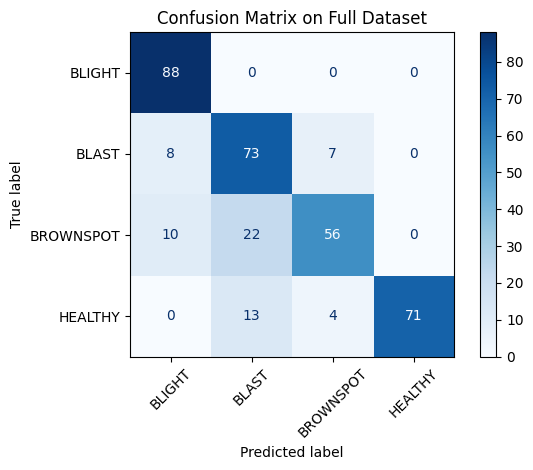


✅ Testing finished.


In [3]:

MODEL_PATH = r"Desktop\Machine Learning\CP_MODEL\DenseNet121_Phase2_GridMask.h5"
# === 5. Load the pre-trained model ===
print(f"✅ Loading model from: {MODEL_PATH}")
model = load_model(MODEL_PATH)
model.summary()

# === 6. Run predictions and evaluate ===
print("\n🚀 Running inference on the test set...")
y_true, y_pred = [], []

# Iterate over the test dataset to get predictions and true labels
for images, labels in test_ds:
    preds = model.predict_on_batch(images) # More efficient for loops
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("✅ Inference complete.")

# === 7. Publish the results ===
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

print("📊 Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Full Dataset")
plt.tight_layout()
plt.show()

print("\n✅ Testing finished.")